__수행 목적__: wafer map의 failure pattern을 manual work 하지 않도 automatically하게 identify하여 반도체 제조에서 웨이퍼 제조 공정의 수율을 향상시킬 수 있다. 

Here, we list all reference:

[1]Wafer Map Failure Pattern Recognition and Similarity Ranking for Large-Scale Data Sets [paper downloas link](https://ieeexplore.ieee.org/document/6932449)

[2]Wafer Defect Patterns Recognition Based on OPTICS and Multi-Label Classification [paper download link](https://ieeexplore.ieee.org/document/7867343)



## Step1: Define your problem

Input: WM-811K dataset provided by [MIR lab](http://mirlab.org/dataSet/public/).

Model: One-VS-One multi-class SVMs.

Output: Failure pattern labels.

In [2]:
# loading libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import os

import warnings
warnings.filterwarnings("ignore")

In [3]:
print(os.listdir("./data"))

['LSWMD.pkl']


## Step2: Prepare your data

Data Selection & Preprocessing: 어떤 데이터가 사용가능이고, 어떤 데이터가 손실되어있고 어떤 데이터를 지워도 되는지 고려한다. 또한, 선택한 데이터를 formatting, cleaning, sampling을하여 구성한다.


- Data summary
- Target distribution
- Missing value check
- Others


In [4]:
# Data summary
df=pd.read_pickle("./data/LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


- 이 dataset은 wafer die Size, lot Name, wafer Index 등의 정보와 811,457개의 wafermap으로 이루어져있다.
- 훈련set, 테스트set 모두 이미 전문가에 의해 분류가 되어있다. 하지만 여기에서는 무시를 하고 새롭게 재설계를 하였다.

In [5]:
# # label extraction  e.g.)[Loc] → Loc　 @failureType, trianTestLabel column
# f_squeeze = lambda x: str(np.squeeze(x))
# df["failureType"] = df["failureType"].map(f_squeeze)
# df["trianTestLabel"] = df["trianTestLabel"].map(f_squeeze)
# df.head()

In [12]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


In [13]:
df.tail()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]
811456,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47543,2.0,[],[]


In [39]:
len(df)

811457

In [40]:
print(len(df['lotName'].value_counts()))


46293


- 이 dataset은 fab(제조라인)의 46293개의 실제 lots(보통 wafer 25장짜리 세트, 웨이퍼의 한 묶음)에서 모였다.
- 하지만 46293개의 lots에는 wafer가 47,543*25=1,157,325개인데, 이는 811,457개의 wafer map 갯수보다 큰 값이다. -> 데이터를 뜯어보자..

웨이퍼 관련 용어 

[링크1](https://m.blog.naver.com/aeu/20005275084)

[링크2](https://codenbike.tistory.com/155)

[링크3](https://m.blog.naver.com/notealus/220824138909)




In [29]:
df['lotName'].value_counts()

lotName
lot1        25
lot26113    25
lot26129    25
lot26125    25
lot26124    25
            ..
lot9377      1
lot33363     1
lot33362     1
lot33337     1
lot31847     1
Name: count, Length: 46293, dtype: int64

In [34]:
df_counts = df['lotName'].value_counts().reset_index()

# 컬럼 이름 변경
df_counts.columns = ['lotName', 'cnt']

df_counts.head()

,lotName,cnt
0,lot1,25
1,lot26113,25
2,lot26129,25
3,lot26125,25
4,lot26124,25


In [36]:
len(df_counts[df_counts['cnt']>=25])

21762

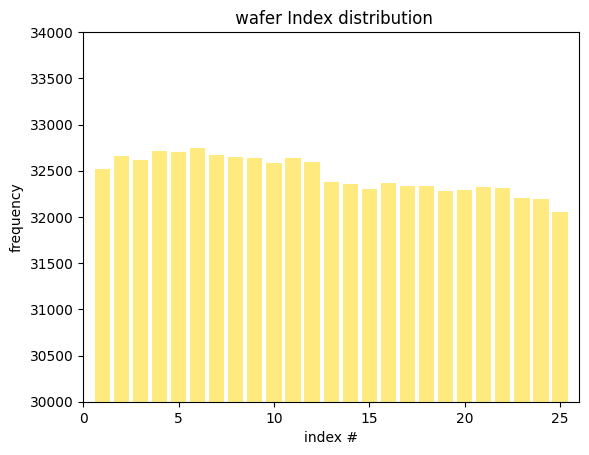

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


uni_Index=np.unique(df.waferIndex, return_counts=True)
plt.bar(uni_Index[0],uni_Index[1], color='gold', align='center', alpha=0.5)
plt.title(" wafer Index distribution")
plt.xlabel("index #")
plt.ylabel("frequency")
plt.xlim(0,26)
plt.ylim(30000,34000)
plt.show()

uni_Index로 waferIndex의 고유값의 개수를 확인한다. 즉, waferIndex의 분포를 확인하면 

wafer map 하나당 25개씩의 lots를 갖는게 통상적인데, 아닌 경우도 많다는것을 볼 수 있다. 이는 sensor failure나 웨이퍼의 불량이거나 일 수 있겠다.


지금은 해당 feature를 제거하는데 나중에 뭐 멀티모달이나 그럴때 사용할 수 있겠다.


In [9]:
df=df.drop(['waferIndex'], axis=1)

- 다이 사이즈(dieSize)가 다 다르다는 것을 알 수 있다.
- 그래서 새로운 변수 'waferMapDim'을 만들어서 사용하자.

array값인 'waferMap'에서 가로 세로 길이를 뽑아낸다.

In [10]:
def find_dim(x):                # 'waferMap' 값을 받아 
    dim0=np.size(x, axis=0)
    dim1=np.size(x, axis=1)
    return dim0, dim1

df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim
566052,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot35522,[],[],"(32, 29)"
584993,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",846.0,lot36487,[],[],"(33, 33)"
299352,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4423.0,lot18289,[],[],"(74, 76)"
285656,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4096.0,lot17441,[],[],"(72, 72)"
710906,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",516.0,lot43463,[[Training]],[[none]],"(25, 27)"


In [11]:
# 다이 크기가 정말 차이가 크게 만들어냄을 알 수 있다.
max(df.waferMapDim), min(df.waferMapDim)

((300, 202), (6, 21))

In [12]:
# np.unique를 통해 다이 사이트의 종류가 몇개나 될까 확인 
uni_waferDim=np.unique(df.waferMapDim, return_counts=True)
uni_waferDim[0].shape[0]

632

- 다이 사이즈가 정말 작은것부터 큰것까지 
- 그 크기 종류도 많다. 
- 일관된 웨이퍼를 만드는것이 아닌가보네?

## 결측 데이터를 확인

trianTestLabel랑 failureType를 보니깐 어떤건 [[Test]] 라던가 [[none]] 이라던가 값이 있는데, 어떤것은 [] 빈값이다.

failureType의 종류가 무엇이 있는지 확인해보자

In [13]:
# 리스트 안의 유니크 값 추출
unique_failure_types = np.unique([item for sublist in df['failureType'] for item in sublist])
print(unique_failure_types)

['Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch' 'none']


In [14]:
unique_trainTestNum_types = np.unique([item for sublist in df['trianTestLabel'] for item in sublist])
print(unique_trainTestNum_types)

['Test' 'Training']


In [15]:
df['failureNum']=df.failureType
df['trainTestNum']=df.trianTestLabel

In [16]:
# mapping_type = {failure_type:i for i, failure_type in enumerate(unique_failure_types)}
mapping_type={'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3, 'Loc':4, 'Random':5,'Scratch':6, 'Near-full':7, 'none':8}
mapping_traintest={'Training':0, 'Test':1}


df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
# failure type label이 없는 데이터 (none값은 제거?)

In [17]:
df.head()

,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)",8,0


In [18]:
tol_wafers=df.shape[0] # 행 갯수 반환

tol_wafers
# 전체 데이터 811457

811457

In [19]:
# 라벨이 있는 df (failureType 전부)
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]        # 새로운 데이터 프레임 생성
df_withlabel = df_withlabel.reset_index()                               # 앞에서 생성한 데이터 프레임의 인덱스 재설정

# 패턴이 있는 df (failureType이 none인 경우는 제외)
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]      # 새로운 데이터 프레임 생성
df_withpattern = df_withpattern.reset_index()                           # 데이터 프레임 인덱스 재설정

# 패턴이 없는 df (failureType이 none인 경우)
df_nonpattern = df[(df['failureNum']==8)]                               # 새로운 데이터 프레임 생성

df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]  # 각 데이터 프레임 행 갯수 반환

(172950, 25519, 147431)

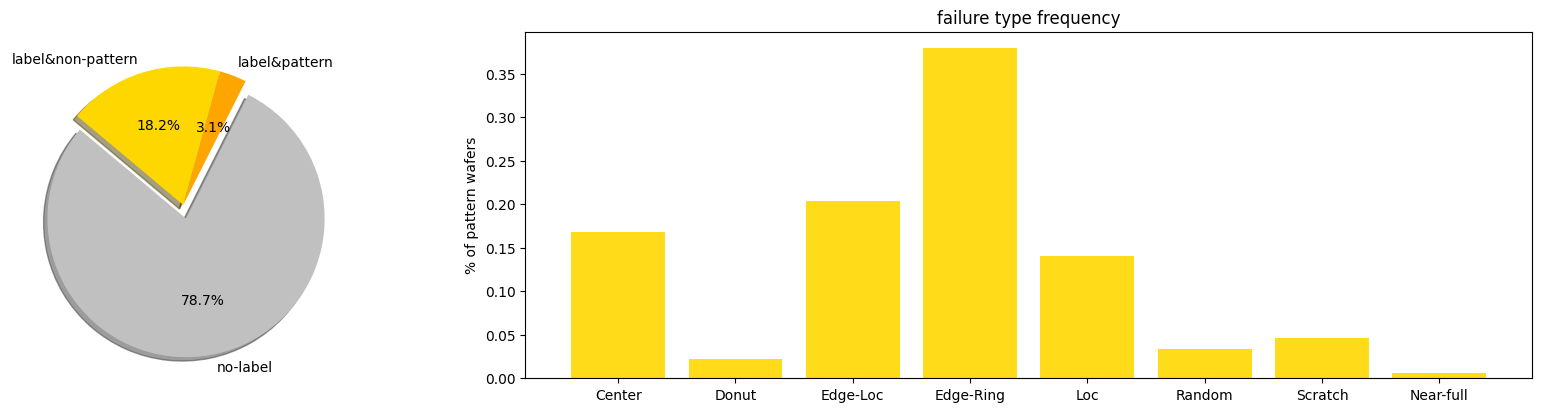

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


no_wafers=[tol_wafers - df_withlabel.shape[0], df_withpattern.shape[0], df_nonpattern.shape[0]]

colors = ['silver', 'orange', 'gold']
explode = (0.1, 0, 0)  # explode 1st slice
labels = ['no-label','label&pattern','label&non-pattern']
ax1.pie(no_wafers, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], color='gold', align='center', alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

- failType의 결측치가 존재한다. 즉 no-label이 이에 해당한다. 이는 전체 78.7%를 차지한다.
- failType을 알아보면 9종류가 있고, 이중 하나는 none이고 나머지는 불량의 종류 pattern('Center' 'Donut' 'Edge-Loc' 'Edge-Ring' 'Loc' 'Near-full' 'Random'
 'Scratch')이 표기되어있다.
- 이것이 전체 3.1%를 차지하는 label&pattern 부분이다. 

- 라벨링된 wafer 중에, 3.1%인 25,519개의 wafer는 failure pattern을 가지고 있다 
- 결국 우리는 25,519개의 데이터만 가지고 수행한다. df['failureNum']가 0에서 7사이, none을 제외한것
- failure type은 8가지이다.

## 시각화

- 데이터를 좀 한눈에 보기 위해 데이터 시각화
- 라벨링 되어있는 데이터(failureNum이 7이하인것들 => df_withpattern)에서 100개의 샘플을 뽑아 봐보자

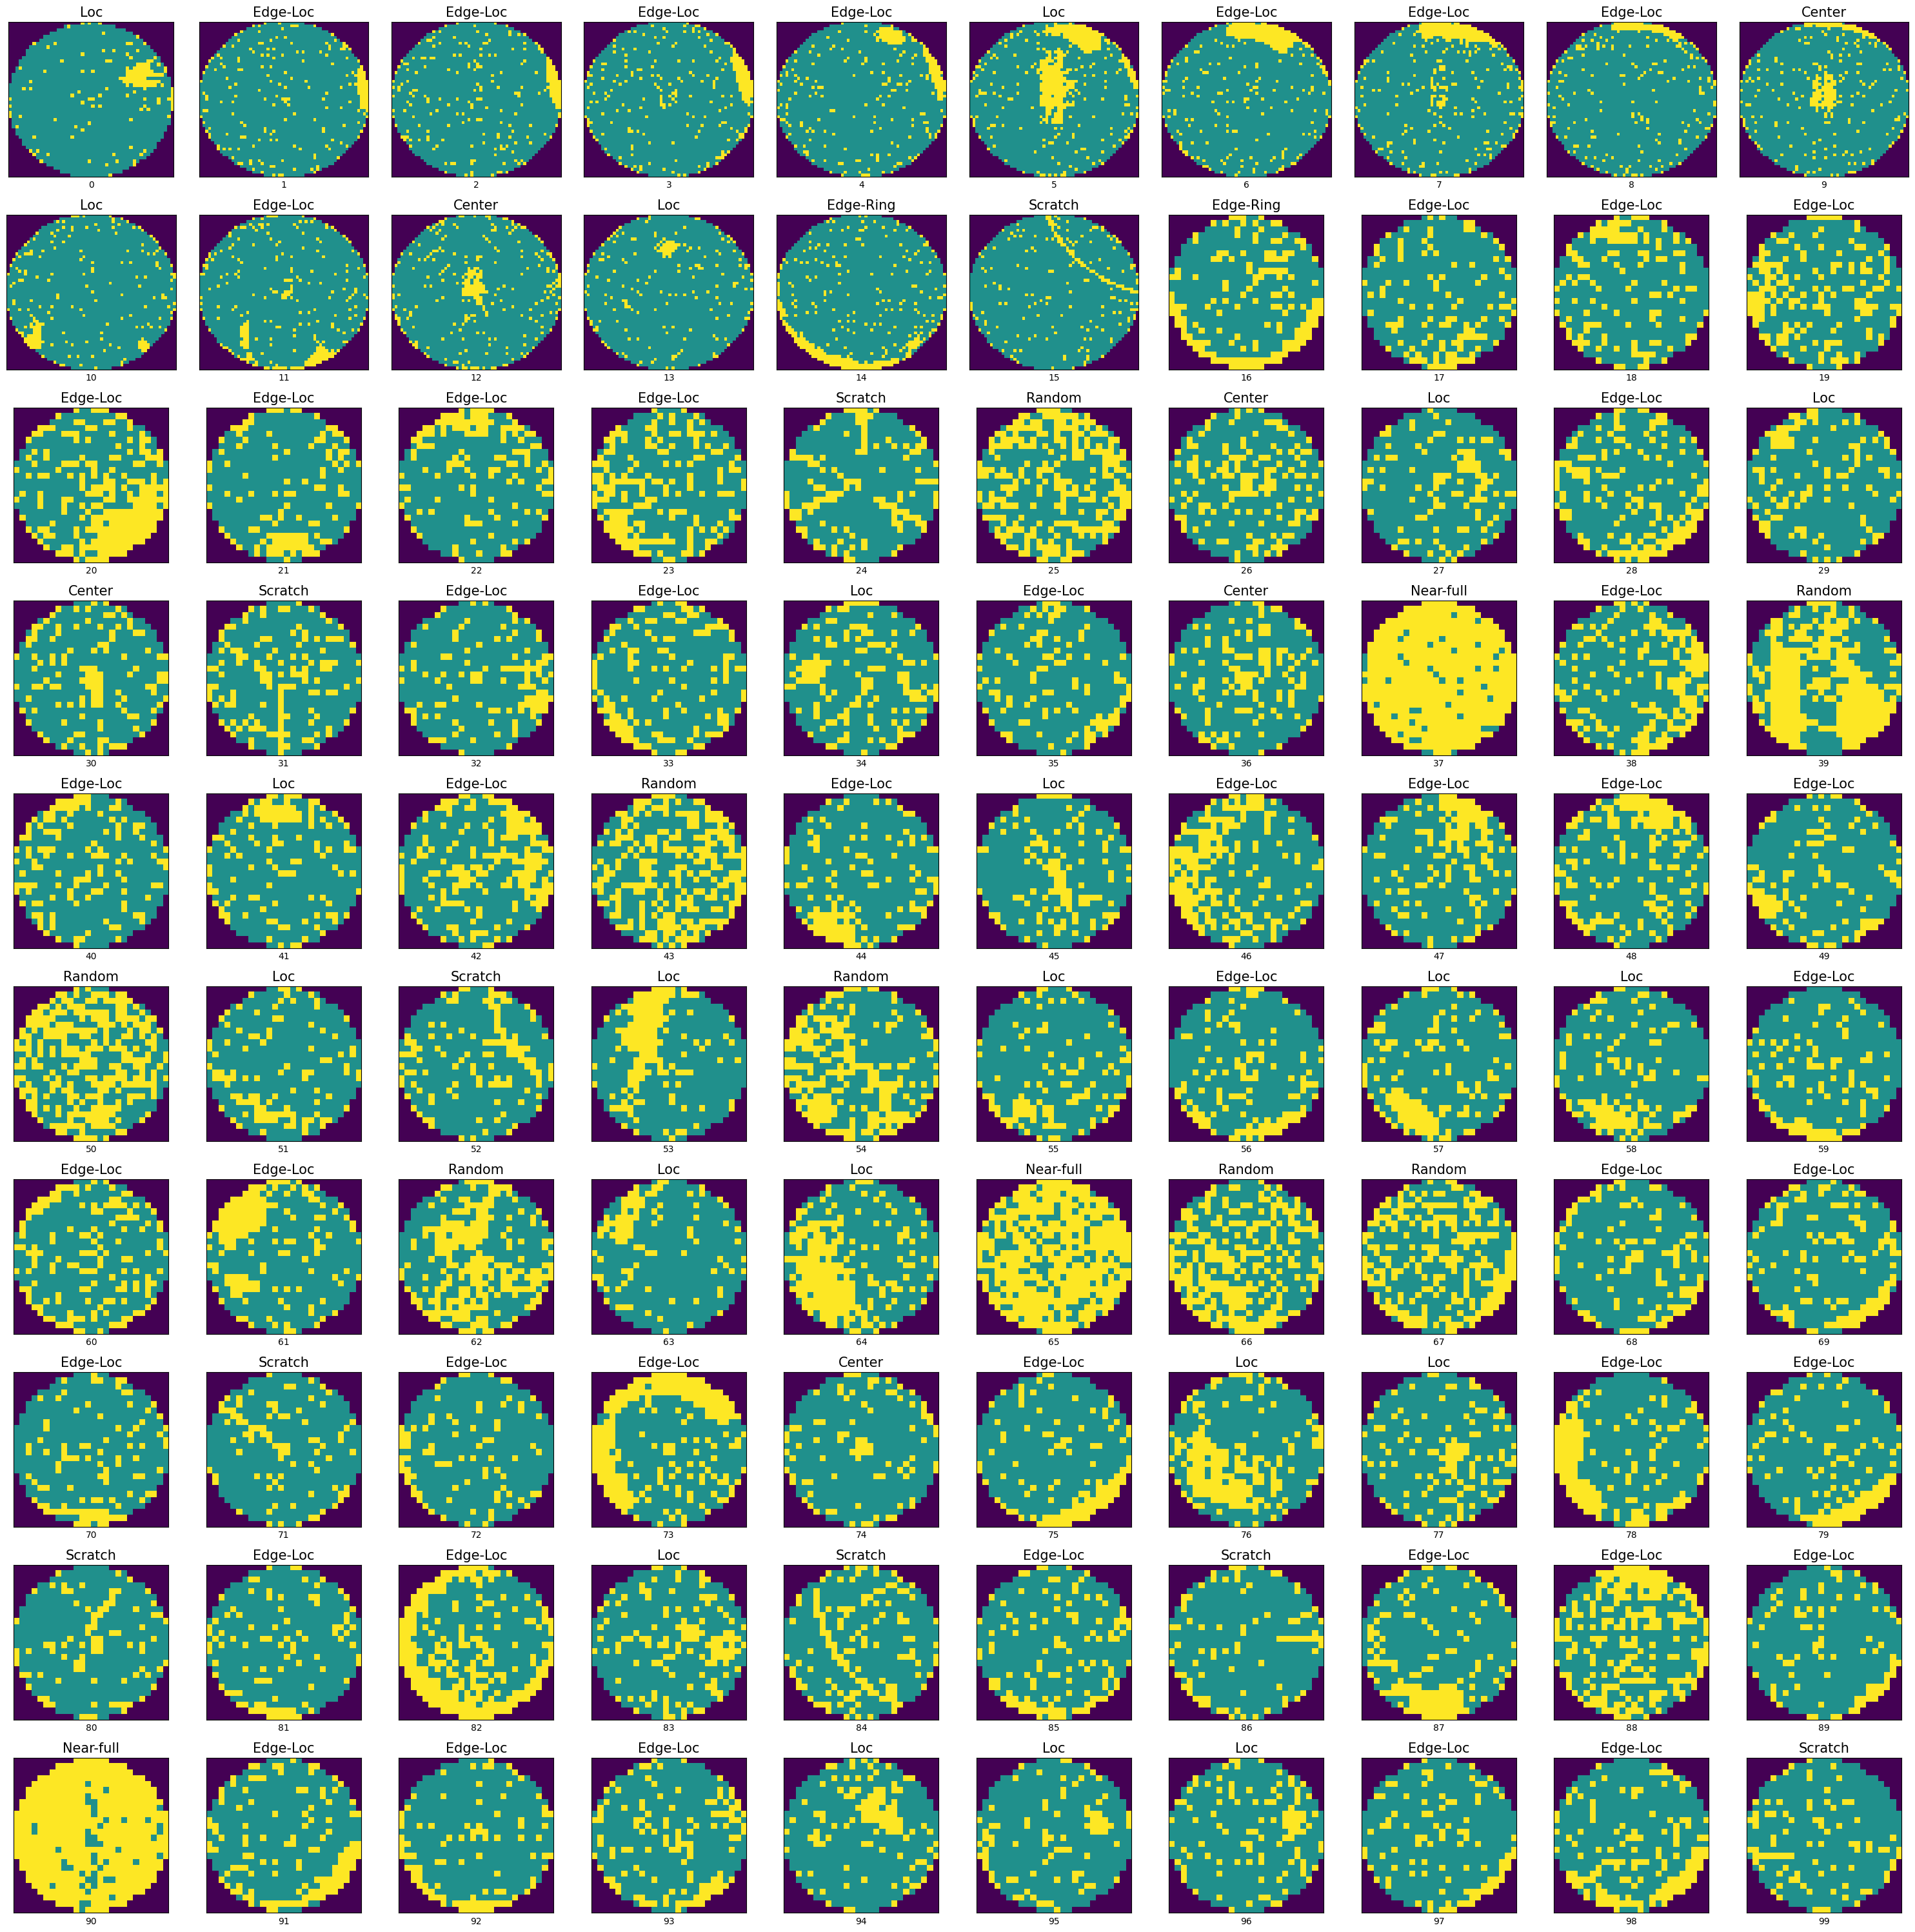

In [26]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(30, 30))
ax = ax.ravel(order='C')
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=15)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

이것들을 6가지 failure type으로 구분해서 봐보자.

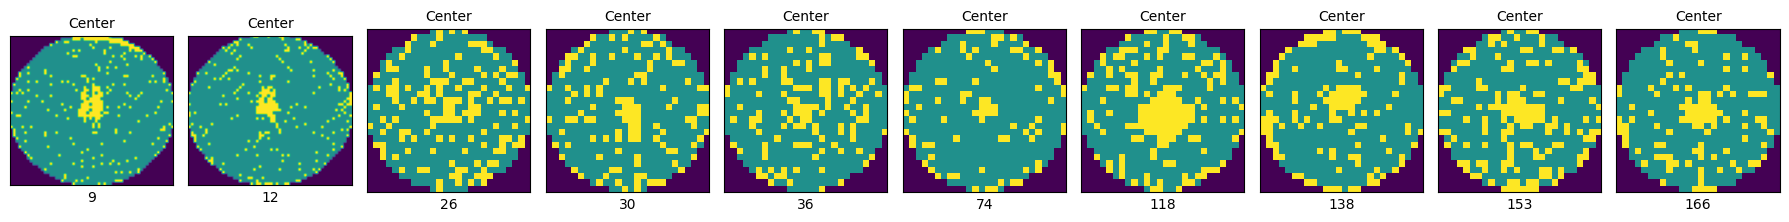

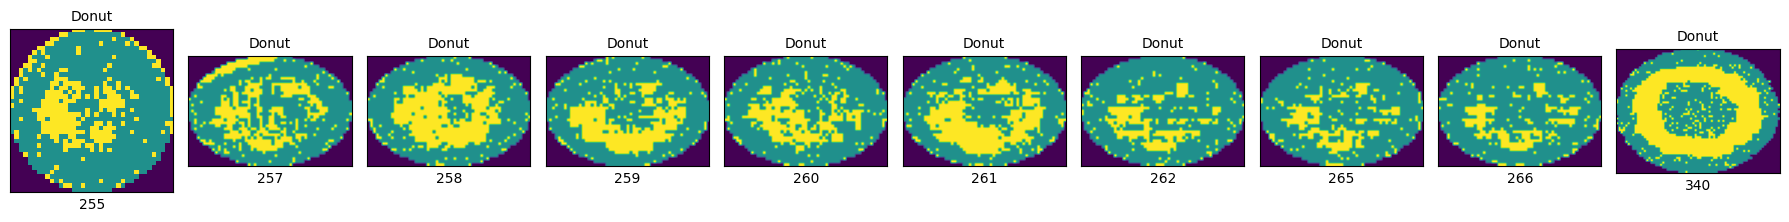

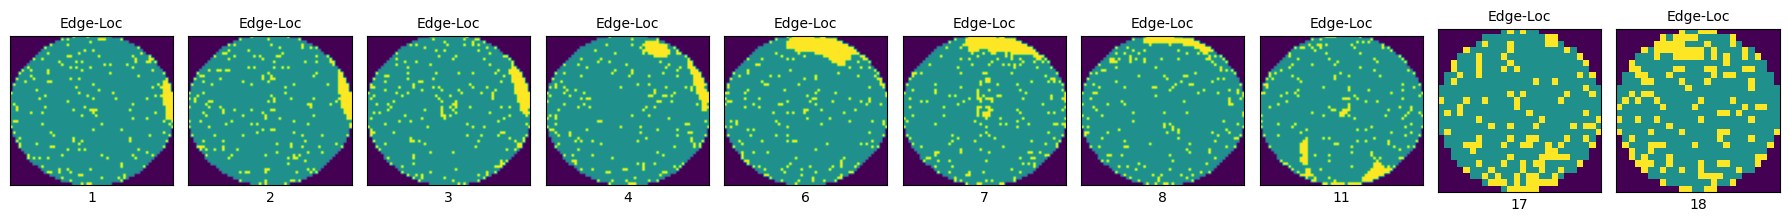

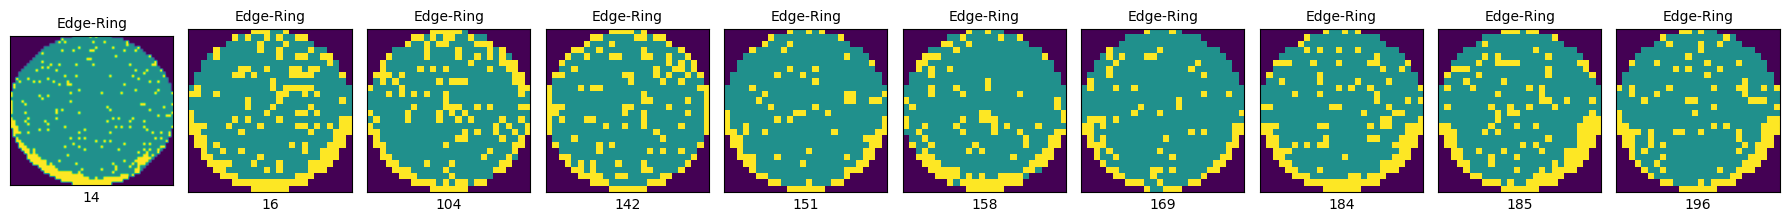

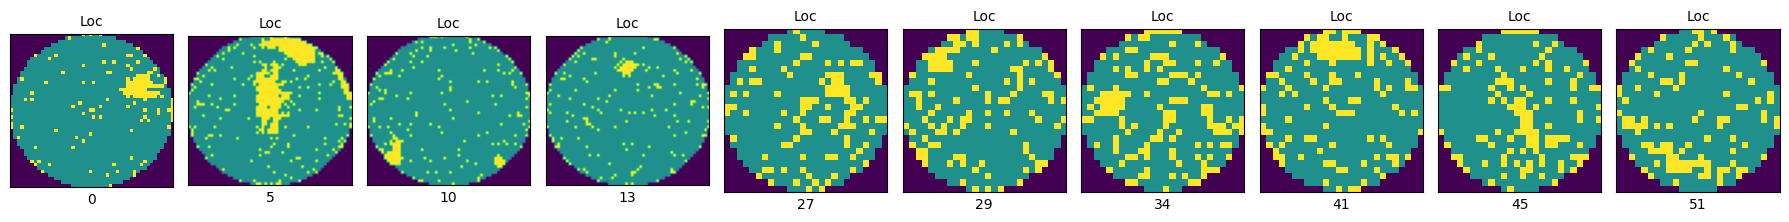

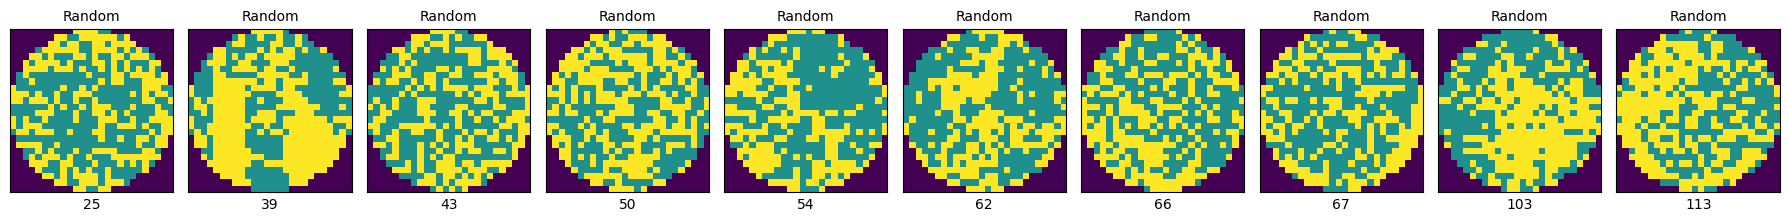

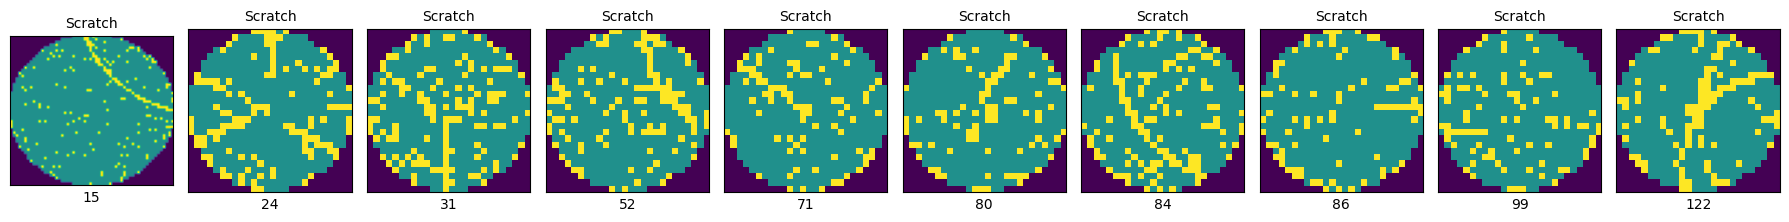

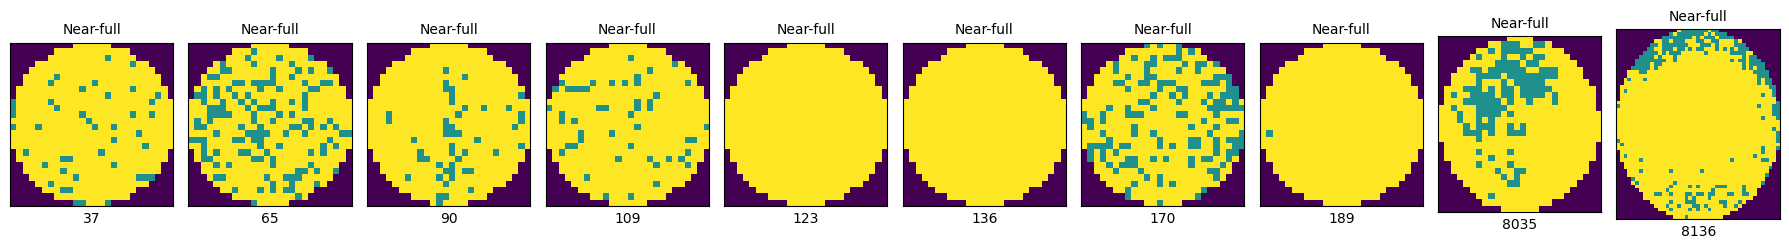

In [27]:
x=[0,1,2,3,4,5,6,7]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

for i in x:
    fig, ax=plt.subplots(nrows=1, ncols=10, figsize=(18,12))
    ax=ax.ravel(order='C') # ravel은 다차원 배열을 1차원으로 변경, C는 기본값
    for j in [i]:
        img=df_withpattern.waferMap[df_withpattern.failureType==labels2[j]]
        for k in range(10):
            ax[k].imshow(img[img.index[k]])
            ax[k].set_title(df_withpattern.failureType[img.index[k]][0][0], fontsize=10)
            ax[k].set_xlabel(df_withpattern.index[img.index[k]], fontsize=10)
            ax[k].set_xticks([])
            ax[k].set_yticks([])
    plt.tight_layout()
    plt.show()

같은 faile type이어도 크기가 다르기도 하네

이번에는 하나씩 뽑아보자.

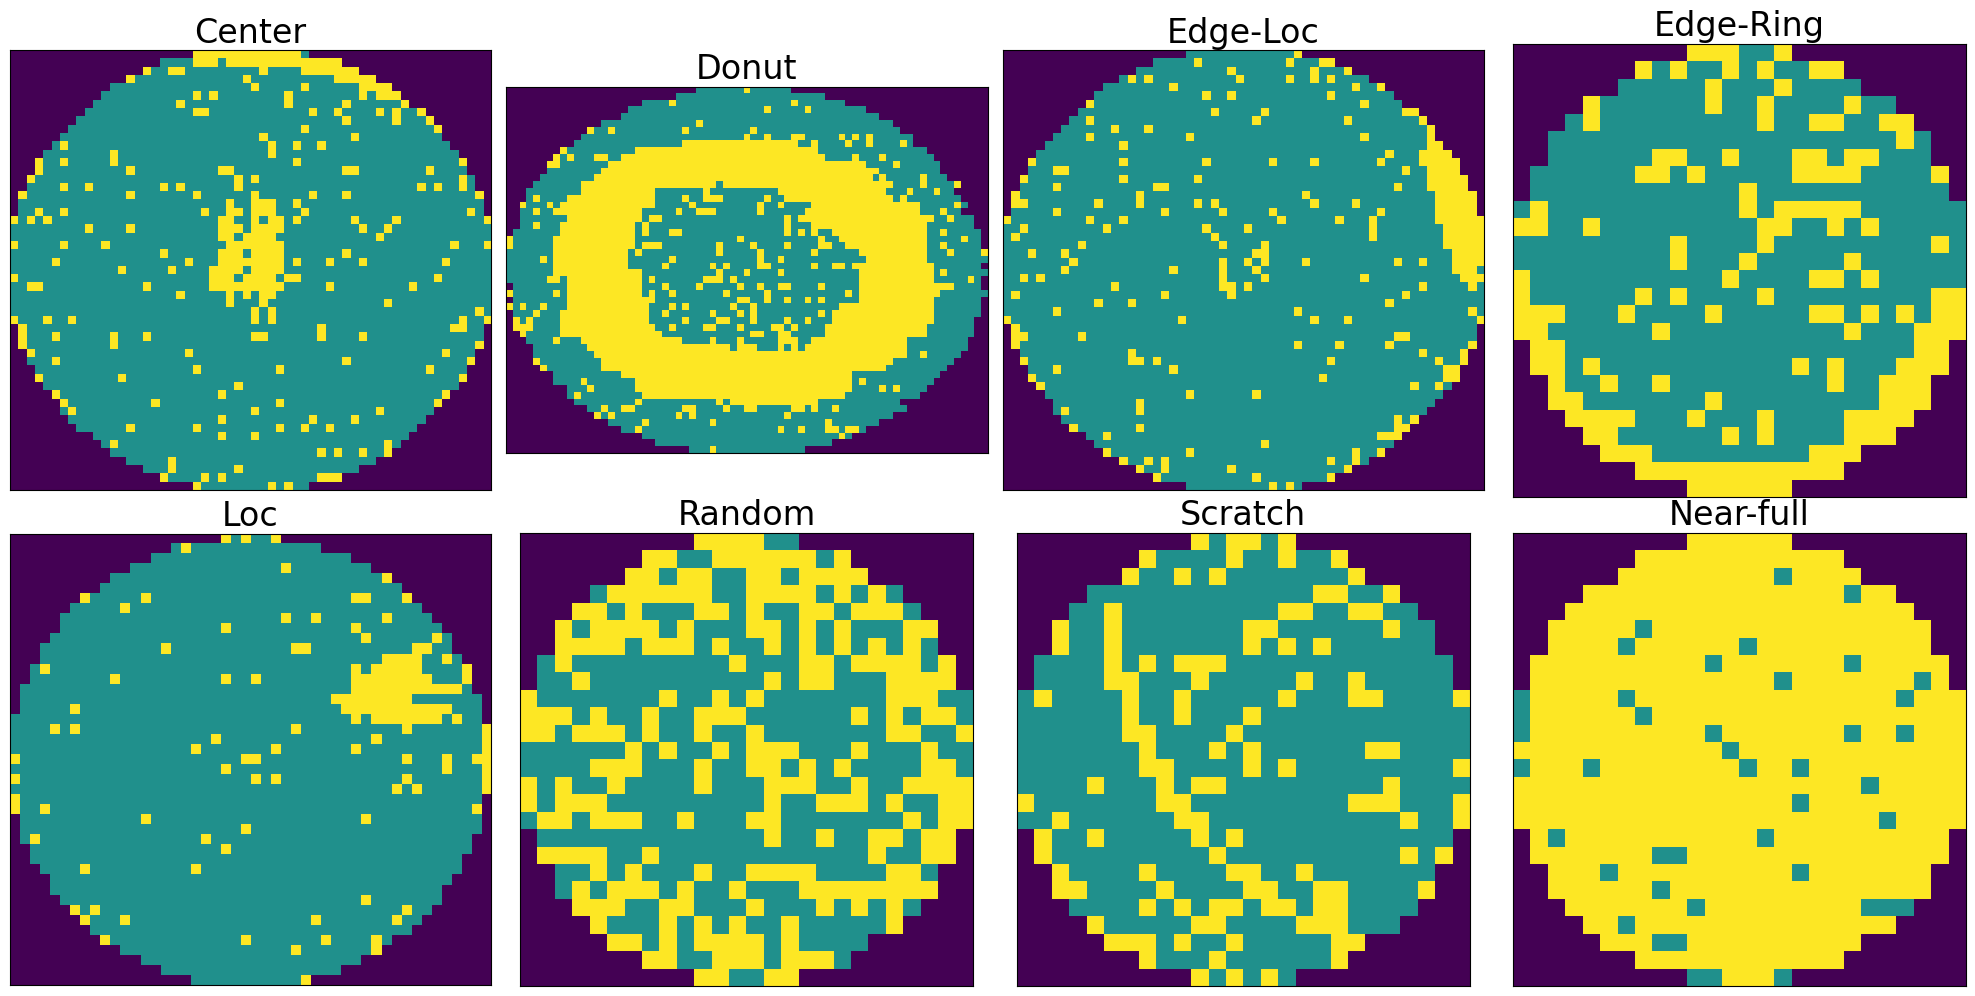

In [28]:
x=[9, 340, 3, 16, 0, 25, 84, 37]
labels2=['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig,ax=plt.subplots(nrows=2, ncols=4, figsize=(20,10))
ax=ax.ravel(order='C')
for i in range(8):
    img=df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0], fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

## Data Transformation

- scaling, attribute decomposition and attribute aggregation을 사용하여 feature engineering을 통해 ML에 사용할 Transform preprocessed data를 준비한다.
- 즉, 머신러닝을 위해 데이터 전처리를 수행한다.

In [29]:
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from skimage import measure
from scipy import interpolate
from scipy import stats

### Density-based Features (13)

- 웨이퍼를 가로선 4개, 세로선 4개로 분할하고 13개의 영역에서 defects density (결함 밀도)를 계산해본다.
- failure pattern에 따라서 밀도의 분포는 다 다를 것이다.
- 예를들어 failure pattern이 Center type인 경우 중앙쪽 밀도가 높을것이다.

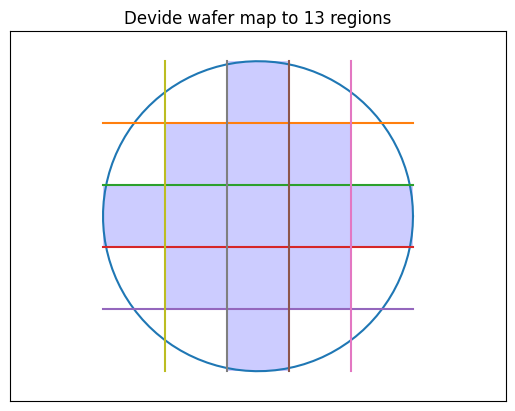

In [30]:
an=np.linspace(0, 2*np.pi, 100)                     # 원 100개의 점 
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))            # 반지름 2.5인 원 그리기 
plt.axis('equal')
plt.axis([-4,4,-4,4])                               # 축 길이 똑같이 

# 가로선 그리기 
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

# 세로선 그리기 
plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])

# 색칠하기 
for i in range(-1, 2):  # x축 범위: -1, 0, 1
    for j in range(-1, 2):  # y축 범위: -1, 0, 1
        x = [i - 0.5, i + 0.5, i + 0.5, i - 0.5]
        y = [j - 0.5, j - 0.5, j + 0.5, j + 0.5]
        plt.fill(x, y, 'blue', alpha=0.2)

x = [-0.5, 0.5, 0.5, -0.5]
y = [1.5, 1.5, 2.5, 2.5]
plt.fill(x, y, 'blue', alpha=0.2) 
x = [-0.5, 0.5, 0.5, -0.5]
y = [-1.5, -1.5, -2.5, -2.5]
plt.fill(x, y, 'blue', alpha=0.2) 
y = [-0.5, 0.5, 0.5, -0.5]
x = [-1.5, -1.5, -2.5, -2.5]
plt.fill(x, y, 'blue', alpha=0.2) 
y = [-0.5, 0.5, 0.5, -0.5]
x = [1.5, 1.5, 2.5, 2.5]
plt.fill(x, y, 'blue', alpha=0.2) 


plt.title("Devide wafer map to 13 regions")
plt.xticks([]) # 축 없애기
plt.yticks([])
plt.show()

In [31]:
def cal_den(x):
    return 100*(np.sum(x==2)/np.size(x))  

# 13개의 영역에 밀도를 계산해서 
def find_regions(x):
    rows=np.size(x,axis=0)
    cols=np.size(x,axis=1)
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[ind1[0]:ind1[1],:]
    reg3=x[ind1[4]:,:]
    reg4=x[:,ind2[0]:ind2[1]]
    reg2=x[:,ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    fea_reg_den = [cal_den(reg1),cal_den(reg2),cal_den(reg3),cal_den(reg4),cal_den(reg5),cal_den(reg6),cal_den(reg7),cal_den(reg8),cal_den(reg9),cal_den(reg10),cal_den(reg11),cal_den(reg12),cal_den(reg13)]
    return fea_reg_den

In [32]:
# fea_reg에 넣어준다.
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

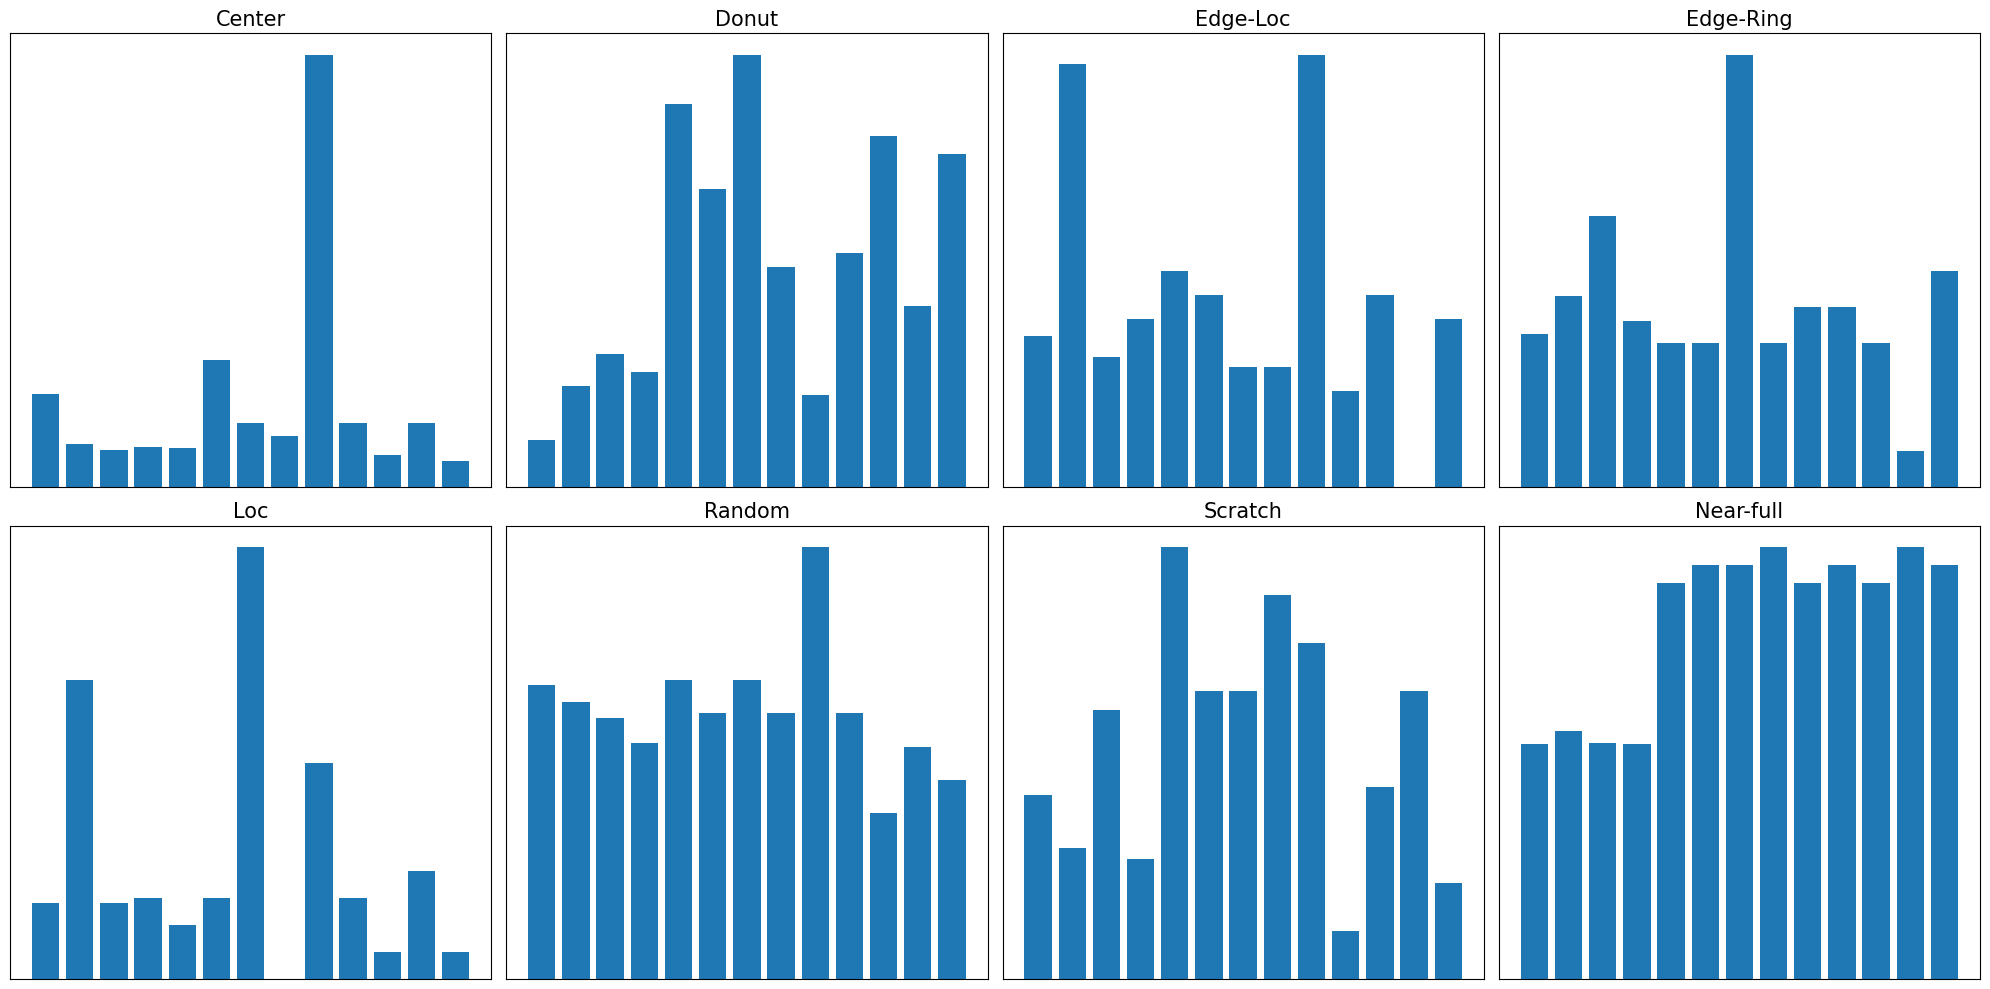

In [33]:
# 각 8개의 fail type에서 각 13개의 구역별 defect density를 그래프로 확인해보자 
x = [9, 340, 3, 16, 0, 25, 84, 37]      # 이 웨이퍼를 확인 
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

확실히 패턴이 보인다.
- failure type의 밀도를 표현한 밀도기반 그래프를 통해 쉽게 분류가 가능한 모델링 가능해 보임

### Randon-based Features (40)

라돈 변환을 기반으로 투영된 wafer map을 2d로 표현가능하다.

간단하게 말하자면 wafer map이라는 2차원 공간 도메인 데이터를 라돈 도메인 데이터로 변환한다. 

- Radon 변환은 일반적으로 이미지를 다양한 각도로 투영하여 생성된 선형 측정 데이터를 의미합니다. 이 변환은 특히 이미지 복원과 CT 스캔 등에서 사용됩니다.

- Radon transform에 대해 알아보기 : [scikit-image link about Radon Transform](https://scikit-image.org/docs/dev/auto_examples/transform/plot_radon_transform.html)

https://swrush.tistory.com/587

In [34]:
from skimage.transform import radon

In [35]:
def change_val(img):
    img[img==1] = 0  
    return img

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] =df_withpattern_copy.waferMap.apply(change_val)

In [36]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

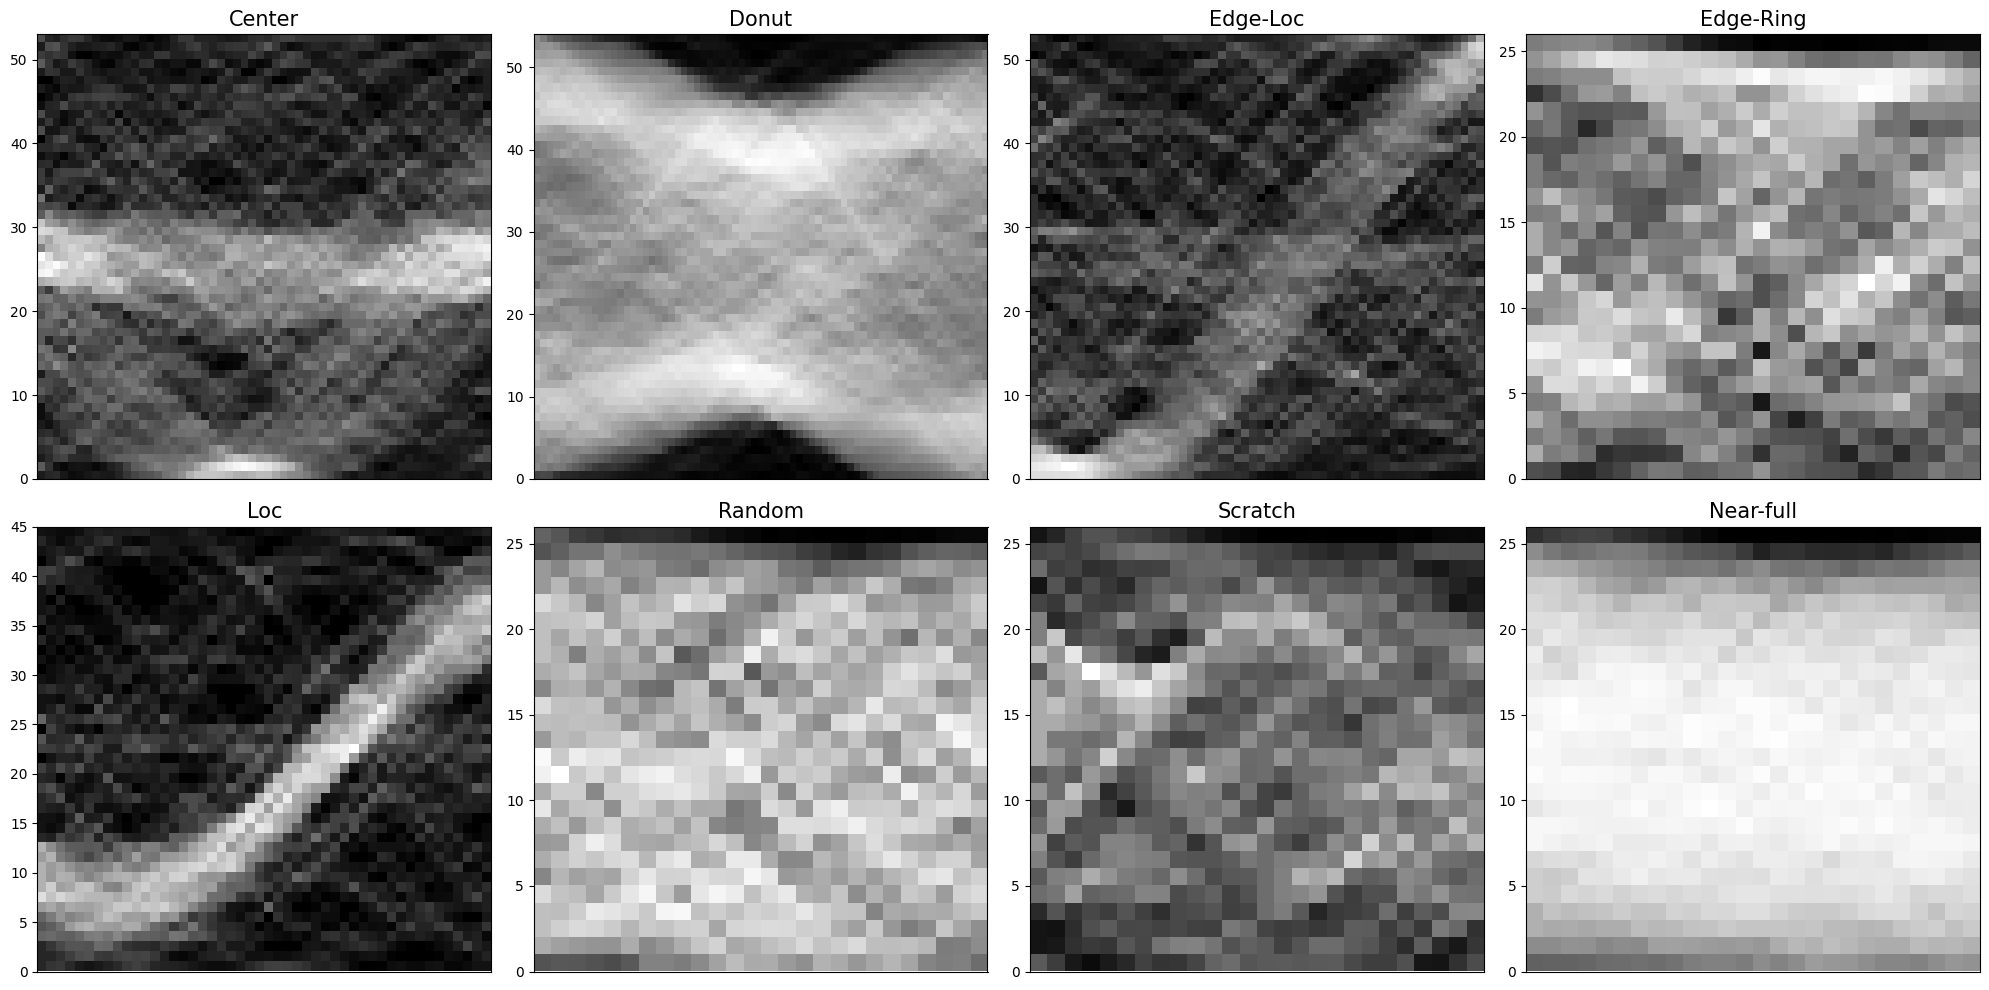

In [37]:
fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)    
      
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show() 

각 failure type의 라돈 변환 결과이다.

이 결과를 통해 라돈 변환을 하면 그 차이를 뚜렷이 확인할 수 있다. 

- 하지만 웨이퍼의 크기가 다 달라서 이것만으로 단정지을 수 없다. 따라서 cubic interpolation을 활용하여, 라돈 변환에서 각 행 평균과 표준편차에 대한 고정된 값을 얻는다. 
- 각각에 대해 차원은 20으로 고정한다.


In [38]:
# 라돈 변환에서 각 행 평균 투영 데이터에서 20개의 차원으로 보간된 값 추출 
def cubic_inter_mean(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)  
    xMean_Row = np.mean(sinogram, axis = 1)                                 # 각 행에 대해 평균값을 계산 : 이 값은 모든 투영 각도에 대해 평균화된 값을 의미
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')                          # xMean_Row에 대한 보간을 수행하기 위해 3차 함수 보간법(큐빅 보간법)을 사용
    xnew = np.linspace(1, xMean_Row.size, 20)                               # 20개의 점으로 균등하게 나누어 생성
    ynew = f(xnew)/100                                                      # use interpolation function returned by `interp1d`
    return ynew                                                             # img에 대한 Radon 변환 후, 큐빅 보간법을 사용하여 얻은 평균 투영 데이터의 20개의 보간된 값

# 라돈 변환에서 각 행 표준편차 투영 데이터에서 20개의 차원으로 보간된 값 추출 
def cubic_inter_std(img):
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    sinogram = radon(img, theta=theta)
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)/100   # use interpolation function returned by `interp1d`
    return ynew 


In [39]:
df_withpattern_copy['fea_cub_mean'] = df_withpattern_copy.waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] = df_withpattern_copy.waferMap.apply(cubic_inter_std)

라돈 변환의 행 평균 20 보간으로 얻은 데이터를 각 fail type별로 시각화 해보자.

__Radon-based feature (interpolate from row mean)__

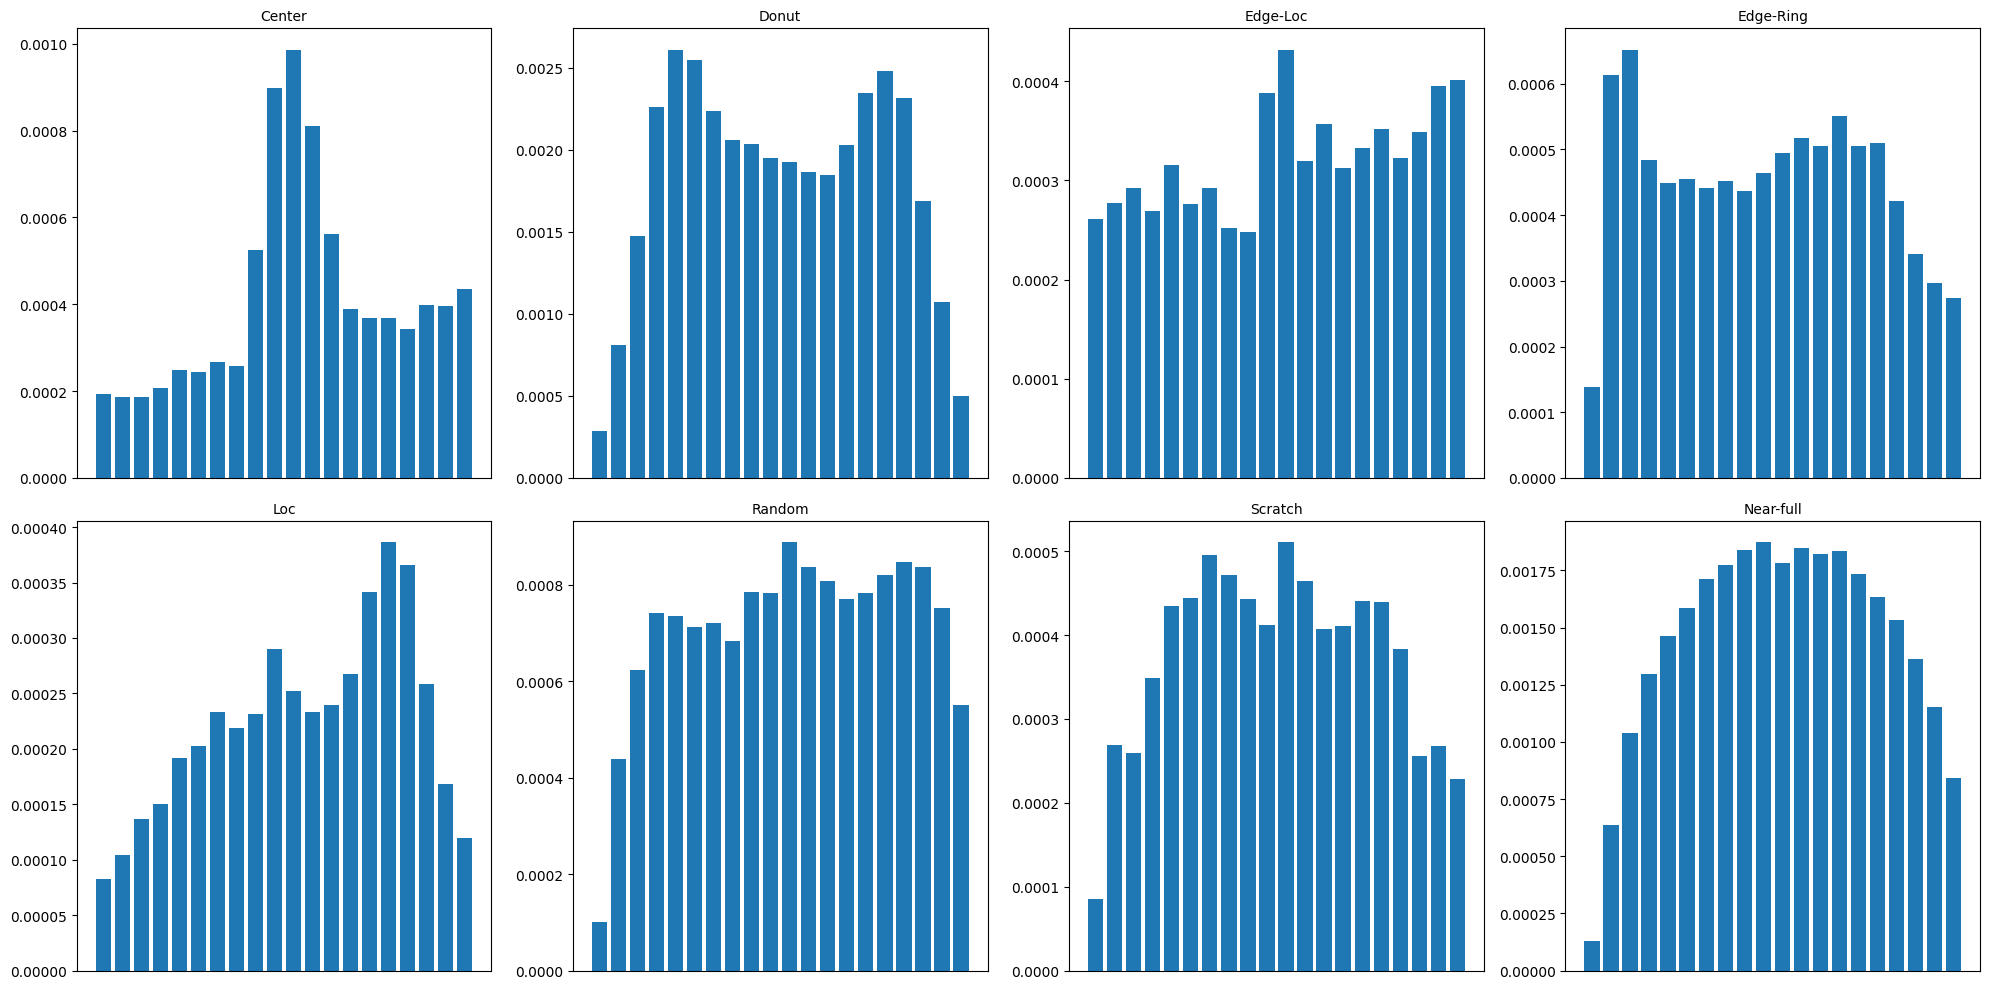

In [43]:
x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    # ax[i].set_xlim([0,21])   
    # ax[i].set_ylim([0,1])
plt.tight_layout()
plt.show() 

라돈 변환의 행 표준편차 20 보간으로 얻은 데이터를 각 fail type별로 시각화 해보자.

__Radon-based feature (interpolate from row standard deviation)__

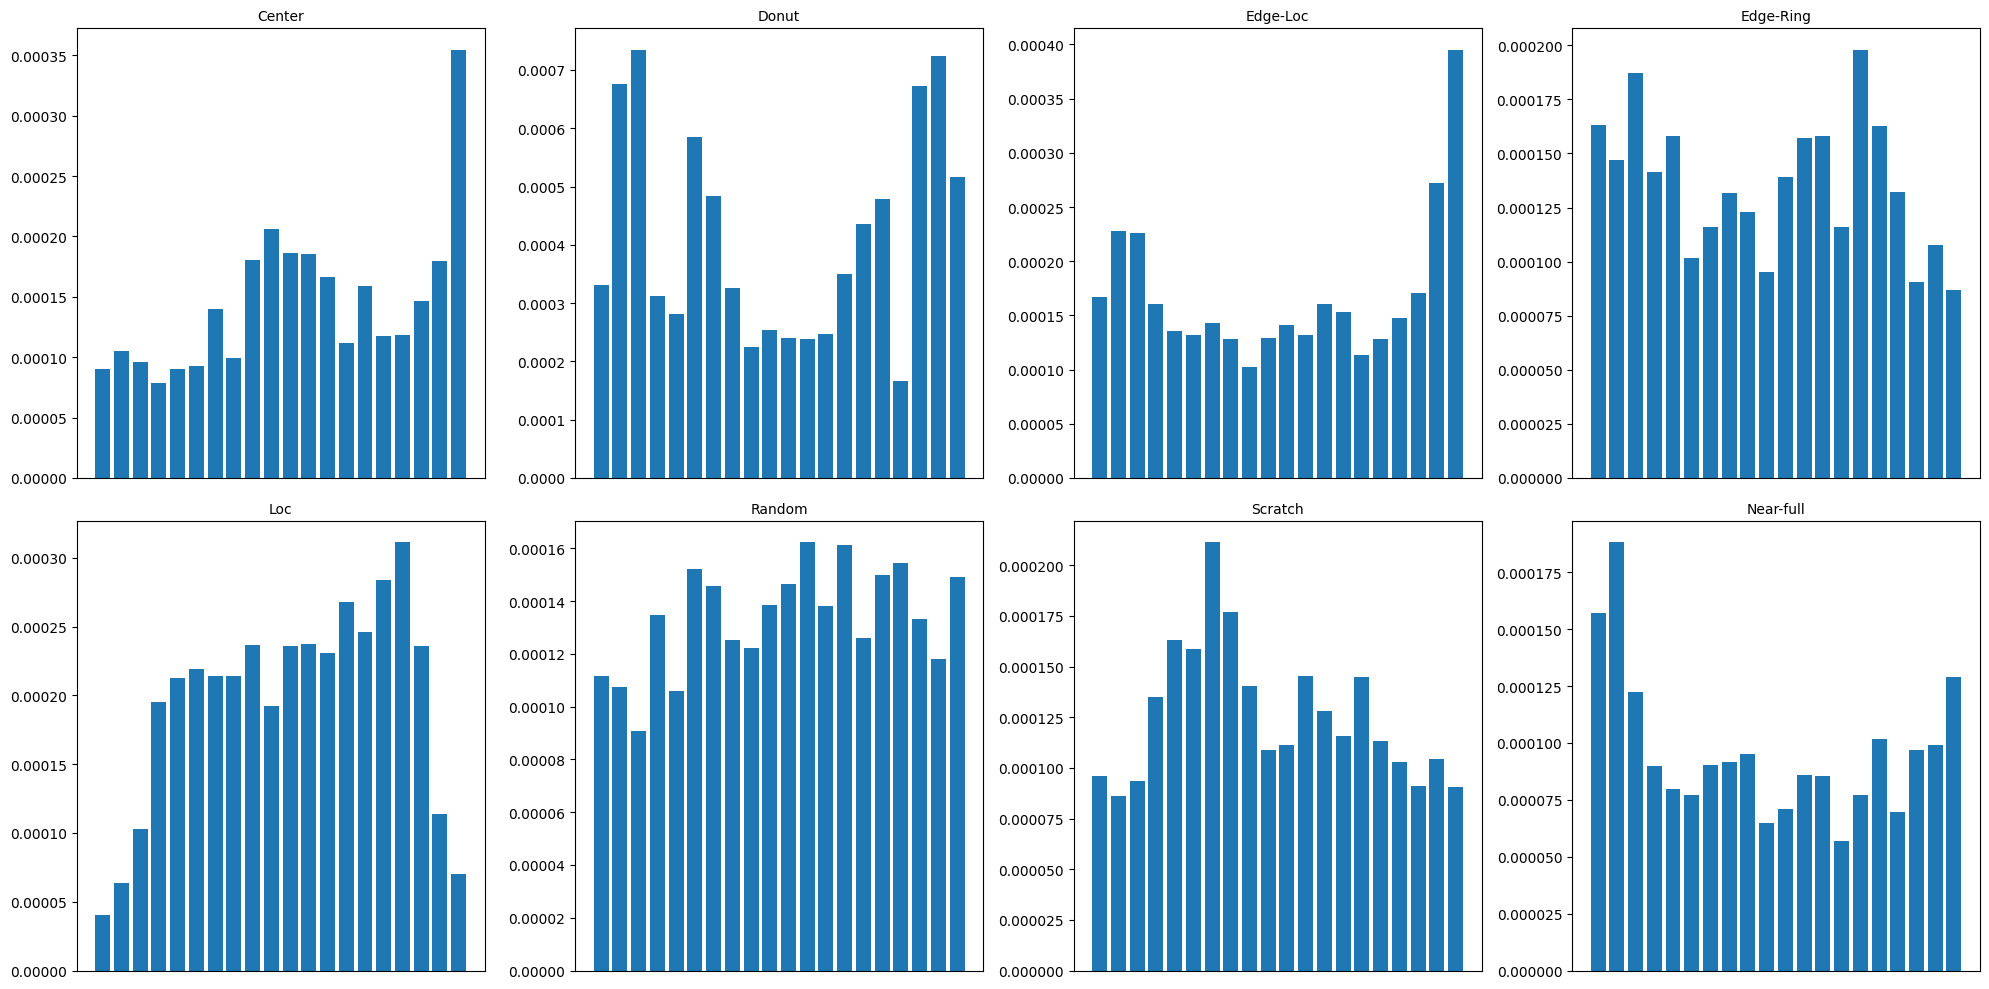

In [44]:
fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    # ax[i].set_xlim([0,21])   
    # ax[i].set_ylim([0,0.3])
plt.tight_layout()
plt.show() 

__Geometry-based Features (6)__

- 노이즈 필터링을 통해 가장 구분되는 영역을 식별할 수 있다. -> measure.label를 통해
- 따라서 가장 구분되는 부분의 최대 영역을 고르고 region-labeling algorithm을 사용한다.
- 이러한 구분되는 영역에서 area, perimeter, length of major axes, length of minor axes, solidity, rmflrh eccentricity 등의 기하학적 features를 뽑아낸다.



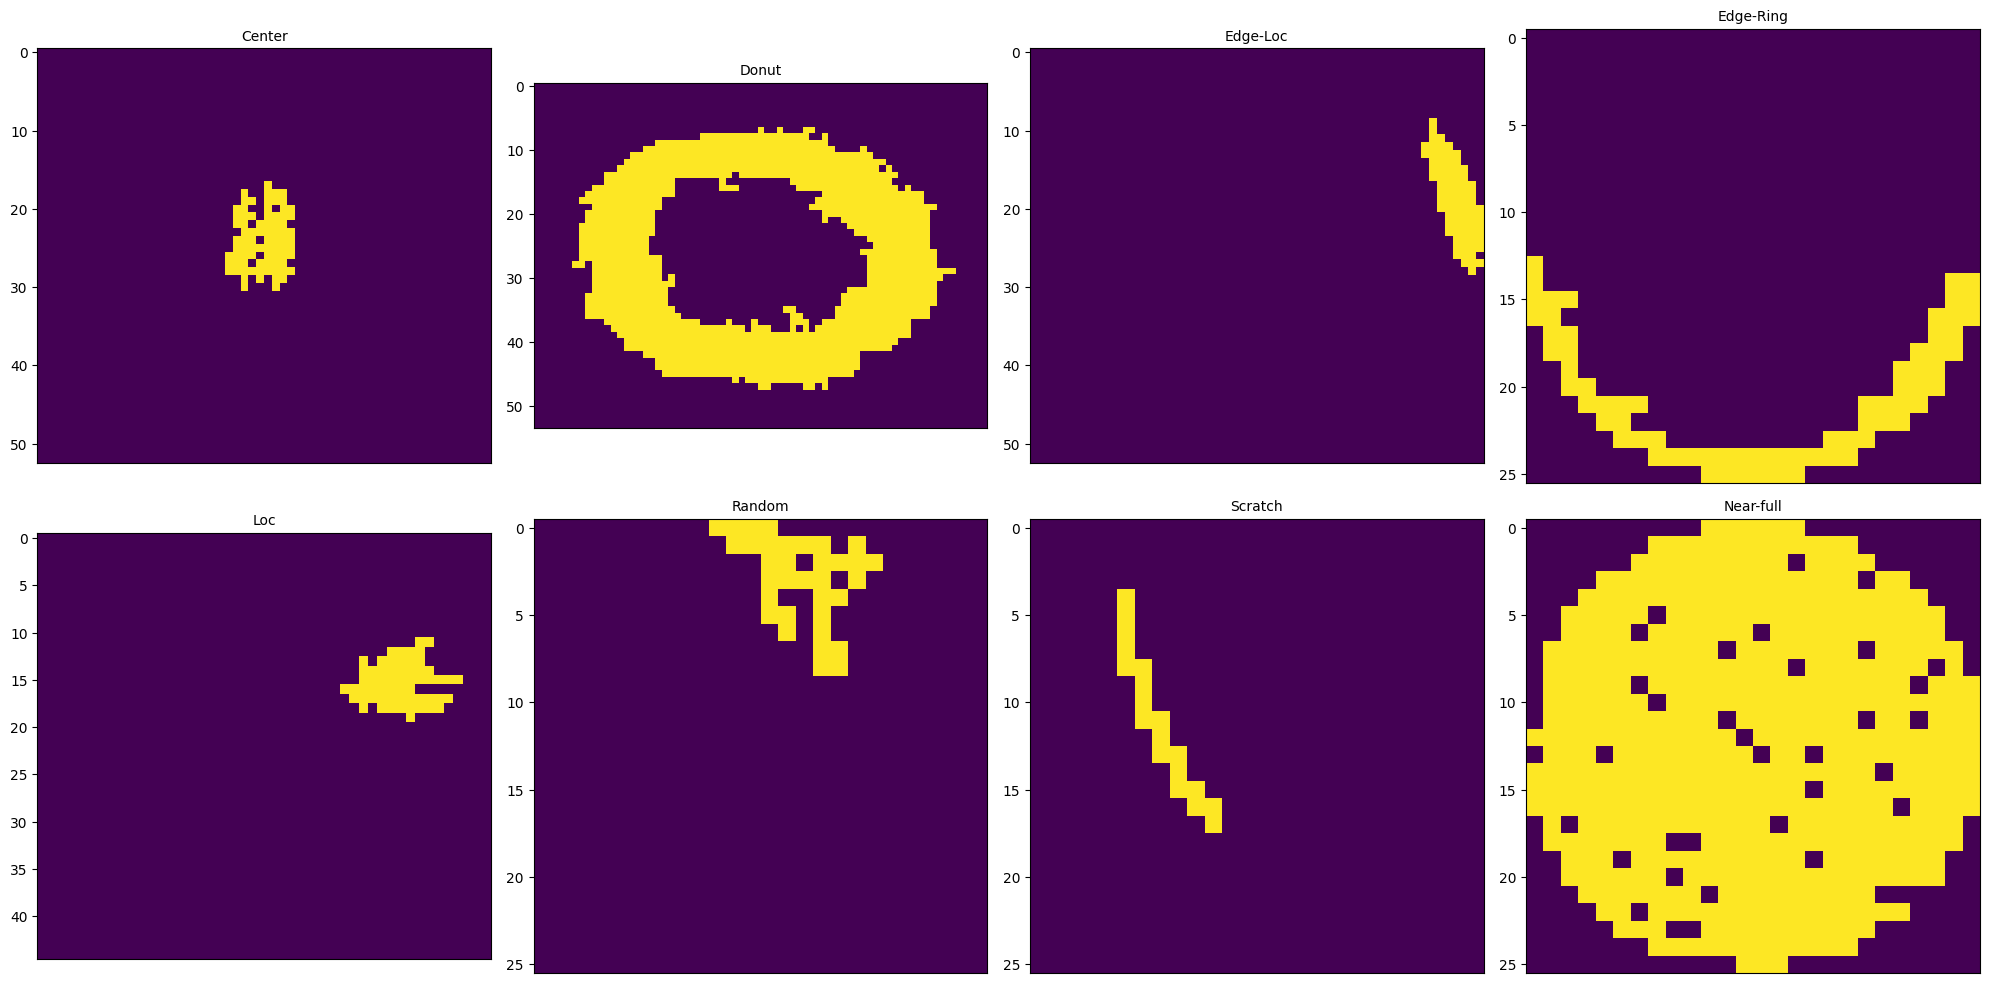

In [48]:
from skimage import measure
from scipy import stats

x = [9, 340, 3, 16, 0, 25, 84, 37]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(8):
    img = df_withpattern_copy.waferMap[x[i]]
    zero_img = np.zeros(img.shape)                                                  # img 크기의 빈 이미지 만들기 
    # 두 픽셀은 이웃이고 같은 값을 가질 때 연결 : 노이즈를 제거하고 각 fail type 별 웨이퍼의 불량을 뚜렷이 두드러지게 보기 위해 
    img_labels = measure.label(img, connectivity=1, background=0)                   # https://pydocs.github.io/p/skimage/0.17.2/api/skimage.measure._label.label.html 참고

    img_labels = img_labels-1
    # 최빈값(대표 영역) 계산
    if img_labels.max()==0:     # img_labels에서 최댓값이 0이면, no_region을 0으로 설정
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>-1], axis = None)        # 0 이상의 img_labels에서 최빈값을 찾아
        no_region = info_region[0]                                              # no_region에 할당
    # 대표 영역 강조:
    zero_img[np.where(img_labels==no_region)] = 2   # zero_img에서 no_region에 해당하는 위치를 2로 설정하여 해당 영역을 강조
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [49]:
# 특정 좌표 x,y 와 이미지 중심까지 거리 계산 -> 이미지에서 특정 지점이 중심으로부터 얼마나 떨어져 있는지를 측정
def cal_dist(img,x,y):
    dim0=np.size(img,axis=0)    
    dim1=np.size(img,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

In [50]:
# 이진 이미지(img)에서 특정한 기하학적 특징들을 추출하여 반환하는 함수
def fea_geom(img):
    norm_area=img.shape[0]*img.shape[1]                                     # 이미지의 총 픽셀 수(면적)를 계산
    norm_perimeter=np.sqrt((img.shape[0])**2+(img.shape[1])**2)             # 이미지의 대각선 길이(정규화된 둘레)를 계산
    
    img_labels = measure.label(img, connectivity=1, background=0)           # 이미지의 연결된 구성 요소(connected components)를 식별하고, 각 구성 요소에 고유한 레이블을 부여

    # 레이블의 가장 큰 영역 뽑기 
    if img_labels.max()==0:
        img_labels[img_labels==0]=1
        no_region = 0
    else:
        info_region = stats.mode(img_labels[img_labels>0], axis = None)
        no_region = info_region[0][0]-1       
    
    # 영역의 기하학적 속성 계산
    prop = measure.regionprops(img_labels)              
    prop_area = prop[no_region].area/norm_area                      # 선택된 영역의 면적을 정규화된 전체 면적으로 나눈 값
    prop_perimeter = prop[no_region].perimeter/norm_perimeter       # 선택된 영역의 둘레를 정규화된 둘레로 나눈 값
    
    prop_cent = prop[no_region].local_centroid                      # 선택된 영역의 무게 중심 좌표
    prop_cent = cal_dist(img,prop_cent[0],prop_cent[1])             # 이미지 중심으로부터의 거리를 계산하여 반환
    
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter # 선택된 영역의 주축 길이를 정규화된 둘레로 나눈 값.
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter # 선택된 영역의 부축 길이를 정규화된 둘레로 나눈 값
    prop_ecc = prop[no_region].eccentricity                         # 선택된 영역의 이심률(0은 원에 가까운 형태, 1에 가까울수록 길쭉한 타원에 가까움).
    prop_solidity = prop[no_region].solidity                        # 선택된 영역의 밀집도(영역 면적을 볼록 껍질(convex hull) 면적으로 나눈 값).
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity
# 함수는 이미지의 연결된 영역을 분석하여 면적, 둘레, 중심점, 주축 및 부축 길이, 이심률, 그리고 밀집도를 계산

In [51]:
# 기하학적 특징들 추가 
df_withpattern_copy['fea_geom'] =df_withpattern_copy.waferMap.apply(fea_geom)

In [52]:
# 340번째 행은 donut임, 이거 확인해보자.
df_withpattern_copy.fea_geom[340]

(0.30881585811163276,
 3.4633305623147477,
 0.7464951525564261,
 0.5214489845402435,
 0.7155811292862498,
 0.6103092783505155)

In [54]:
df_withpattern_copy.head(2)

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum,fea_reg,new_waferMap,fea_cub_mean,fea_cub_std,fea_geom
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[Loc]],"(45, 48)",4,0,"[3.4722222222222223, 13.703703703703704, 3.472...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[8.215024391397317e-05, 0.00010463980628879118...","[4.0417074098845694e-05, 6.363021854617116e-05...","(0.027314814814814816, 0.5954493227790636, 0.1..."
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,0,"[6.0344827586206895, 11.05121293800539, 5.1724...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.0002109536214678039, 0.00023458287259812304...","[0.00014887071778255933, 0.0001421232925195758...","(0.01626545217957059, 0.42137276857016587, 0.2..."


### Combine all features together

지금까지 웨이퍼 맵 이미지 기반으로 추출한 features들을 리마인드 해보자. 

- density-based features: 13

- radon-based features: 40

- geom-based features: 6

최종 : 13+40+6=59

In [55]:
df_all=df_withpattern_copy.copy()
a=[df_all.fea_reg[i] for i in range(df_all.shape[0])] #13
b=[df_all.fea_cub_mean[i] for i in range(df_all.shape[0])] #20
c=[df_all.fea_cub_std[i] for i in range(df_all.shape[0])] #20
d=[df_all.fea_geom[i] for i in range(df_all.shape[0])] #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [57]:
fea_all.shape

(25519, 59)

In [58]:
label=[df_all.failureNum[i] for i in range(df_all.shape[0])]
label=np.array(label)

label

array([4, 2, 2, ..., 3, 2, 3])

In [59]:
len(label)

25519

## Step3: Choose algorithms

해당 데이터셋에 대한 논문을 기반으로 One-Vs-One multi-class SVM을 사웅해본다.

In [68]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from collections import  Counter

# feature 데이터와 정답 데이터 분류하고 훈련데이터와 테스트데이터 분류 
X = fea_all
y = label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)                      
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({3: 7299, 2: 3860, 0: 3238, 4: 2677, 6: 905, 5: 640, 1: 404, 7: 116})
Testing target statistics: Counter({3: 2381, 2: 1329, 0: 1056, 4: 916, 6: 288, 5: 226, 1: 151, 7: 33})


In [64]:
# One-Vs-One
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

In [65]:
clf2 = OneVsOneClassifier(LinearSVC(random_state = RANDOM_STATE)).fit(X_train, y_train)

In [67]:
y_train_pred = clf2.predict(X_train)
y_test_pred = clf2.predict(X_test)

train_acc2 = np.sum(y_train == y_train_pred, axis=0, dtype='float') / X_train.shape[0]
test_acc2 = np.sum(y_test == y_test_pred, axis=0, dtype='float') / X_test.shape[0]

print('One-Vs-One Training acc: {}'.format(train_acc2*100)) #One-Vs-One Training acc: 80.36
print('One-Vs-One Testing acc: {}'.format(test_acc2*100)) #One-Vs-One Testing acc: 79.04

One-Vs-One Training acc: 77.34468885521709
One-Vs-One Testing acc: 76.83385579937304


In [70]:
# 평가하기
print(classification_report(y_train, y_train_pred))
print('Acc Score :', accuracy_score(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3238
           1       0.94      0.04      0.08       404
           2       0.59      0.74      0.66      3860
           3       0.90      0.92      0.91      7299
           4       0.58      0.50      0.54      2677
           5       0.82      0.64      0.72       640
           6       0.77      0.34      0.47       905
           7       0.90      0.72      0.80       116

    accuracy                           0.77     19139
   macro avg       0.80      0.61      0.64     19139
weighted avg       0.78      0.77      0.76     19139

Acc Score : 0.7734468885521709


In [71]:
# 평가하기
print(classification_report(y_test, y_test_pred))
print('Acc Score :', accuracy_score(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1056
           1       1.00      0.07      0.12       151
           2       0.60      0.73      0.66      1329
           3       0.89      0.93      0.91      2381
           4       0.57      0.48      0.52       916
           5       0.78      0.64      0.70       226
           6       0.72      0.37      0.49       288
           7       0.90      0.79      0.84        33

    accuracy                           0.77      6380
   macro avg       0.79      0.62      0.64      6380
weighted avg       0.77      0.77      0.76      6380

Acc Score : 0.7683385579937304


## Step4: Present results

- pattern recognition confusion matrix


In [72]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')  

Confusion matrix, without normalization
Normalized confusion matrix


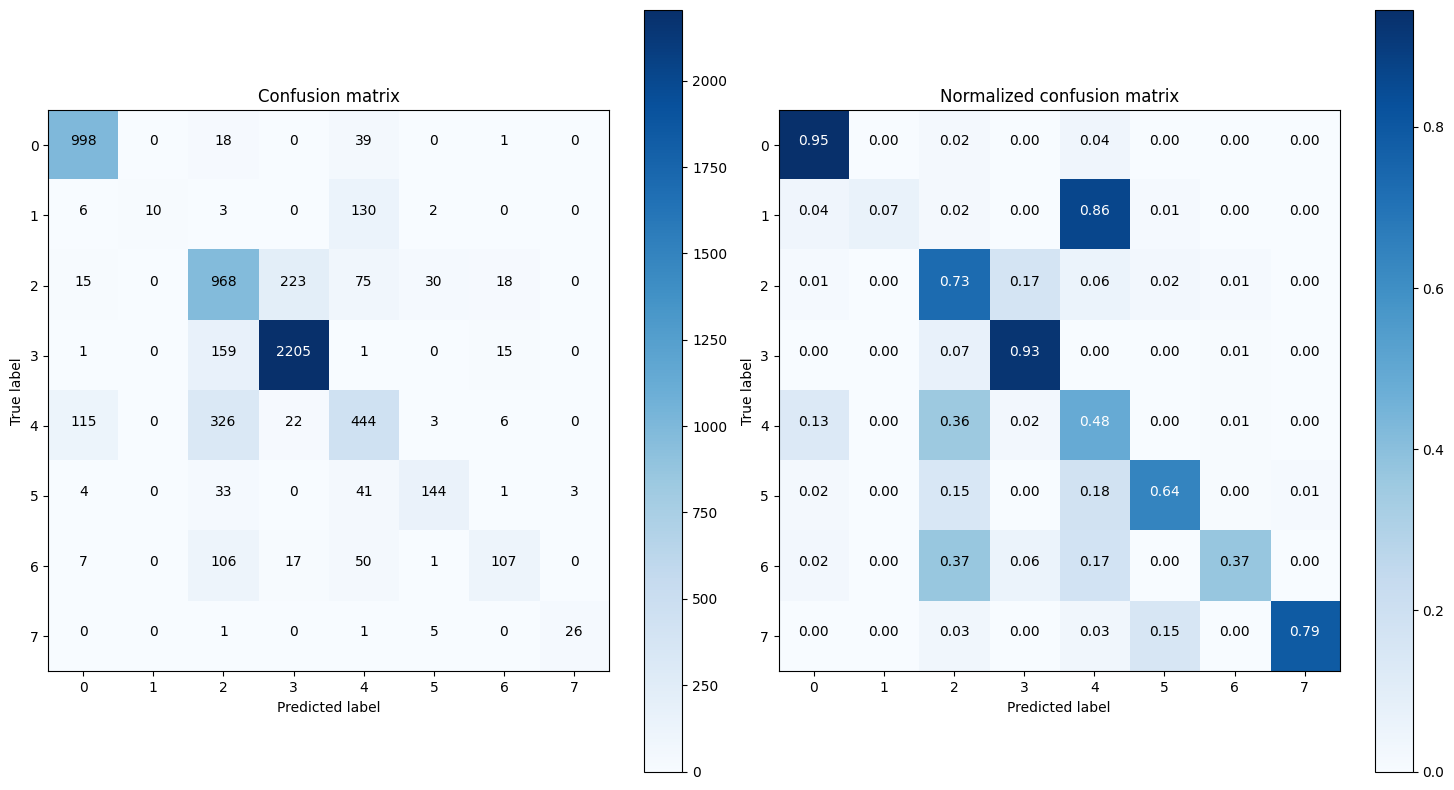

In [76]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
# np.set_printoptions(precision=2)

from matplotlib import gridspec
fig = plt.figure(figsize=(15, 8)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

## Plot non-normalized confusion matrix
plt.subplot(gs[0])
plot_confusion_matrix(cnf_matrix, title='Confusion matrix')

# Plot normalized confusion matrix
plt.subplot(gs[1])
plot_confusion_matrix(cnf_matrix, normalize=True, title='Normalized confusion matrix')

plt.tight_layout()
plt.show()